### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 26th at 11.59pm CT
---

## Problem 1

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [240]:
# Kludge to fix the bug with draw_ellipse in astroML v1.0
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, sigmas=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                             (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 
                   + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in sigmas:
        ax.add_patch(Ellipse((mu[0], mu[1]),
                             2 * scale * sigma1, 2 * scale * sigma2,
                             alpha * 180. / np.pi,
                             **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

#### Part 1

In [107]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [116]:
#Reading in data
data = np.load('/Users/petrop3/Repos/astr_8070_s22/coursework/homeworks/hw_data/hw6_data_1.npy')
dataset = data[:,0:2]
f1 = data[:,0]
f2 = data[:,1]
labels = data[:,2]
print(labels) #printing labels to see what they look like

[1. 1. 1. 2. 1. 4. 4. 1. 3. 2. 3. 0. 4. 3. 1. 0. 4. 4. 2. 2. 1. 4. 4. 1.
 0. 1. 4. 0. 0. 3. 1. 3. 2. 3. 2. 0. 0. 0. 3. 1. 1. 2. 2. 1. 2. 2. 2. 4.
 2. 4. 3. 0. 2. 0. 0. 0. 0. 1. 4. 1. 0. 2. 2. 0. 0. 0. 4. 0. 4. 0. 3. 3.
 1. 4. 1. 2. 0. 1. 4. 3. 0. 4. 3. 1. 2. 3. 0. 3. 0. 0. 3. 0. 4. 2. 4. 0.
 3. 2. 4. 4. 1. 0. 0. 2. 0. 3. 4. 3. 0. 1. 1. 3. 3. 3. 1. 3. 3. 4. 3. 1.
 3. 3. 2. 1. 3. 0. 1. 4. 4. 4. 3. 3. 2. 1. 1. 3. 1. 0. 4. 0. 2. 4. 3. 4.
 1. 2. 3. 1. 3. 4. 4. 2. 4. 4. 1. 4. 4. 4. 1. 2. 1. 3. 0. 2. 1. 0. 3. 3.
 0. 4. 1. 4. 2. 2. 0. 0. 0. 4. 3. 1. 3. 1. 1. 1. 4. 1. 2. 0. 0. 3. 0. 3.
 1. 2. 3. 3. 0. 4. 1. 3. 0. 0. 4. 2. 2. 1. 4. 3. 0. 1. 3. 0. 4. 2. 4. 4.
 2. 4. 1. 0. 4. 1. 1. 4. 4. 2. 3. 2. 2. 1. 3. 1. 0. 4. 1. 1. 1. 3. 0. 4.
 0. 2. 1. 1. 4. 0. 1. 3. 0. 4. 4. 4. 1. 1. 0. 1. 2. 0. 0. 3. 0. 1. 3. 3.
 2. 1. 0. 0. 1. 4. 1. 0. 1. 2. 0. 2. 0. 1. 3. 4. 1. 1. 3. 3. 3. 2. 2. 1.
 0. 2. 0. 0. 4. 4. 2. 3. 1. 2. 2. 2. 1. 1. 3. 0. 3. 2. 1. 0. 2. 0. 3. 0.
 2. 0. 0. 1. 2. 4. 2. 0. 3. 3. 4. 2. 2. 3. 1. 1. 1.

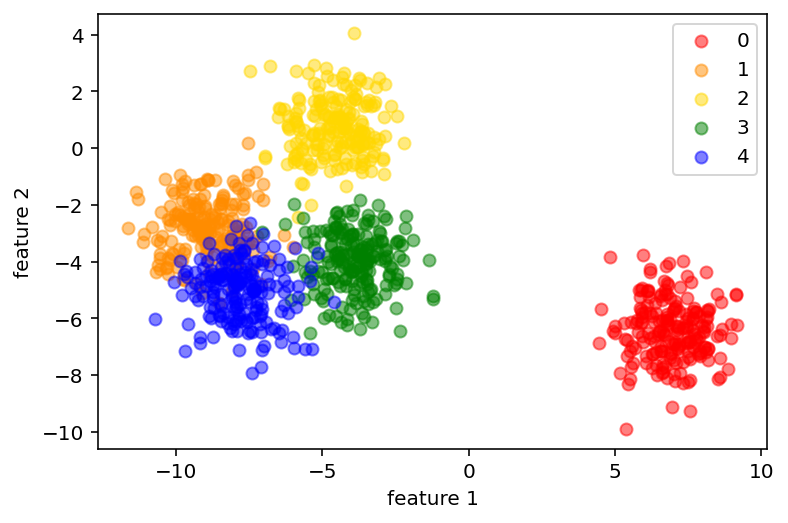

In [117]:
#Plotting points colored by label
colors = ['r','darkorange','gold','g','b']
for i,c in zip(range(5),colors):
    ind = np.where(labels == float(i))
    plt.scatter(f1[ind], f2[ind], color=c, marker='o', alpha=0.5, label=str(i))
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

#### Part 2

In [5]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [80]:
bwrange = np.linspace(0.1, 1.0, 30) #testing 30 bandwidths from 0.1 to 1.0
K = 5 #for 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv=K) #trying each bandwidth with K-folds
grid.fit(dataset) #fitting to data (excluding labels)
h_opt = grid.best_params_['bandwidth']
print('Optimal bandwidth:', h_opt)

Optimal bandwidth: 0.4724137931034482


/var/folders/tq/_zbt6tvn54j23tbg267ynw3c0000gr/T/ipykernel_38391/239383264.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  Xgrid = np.vstack(map(np.ravel, np.meshgrid(x, y))).T


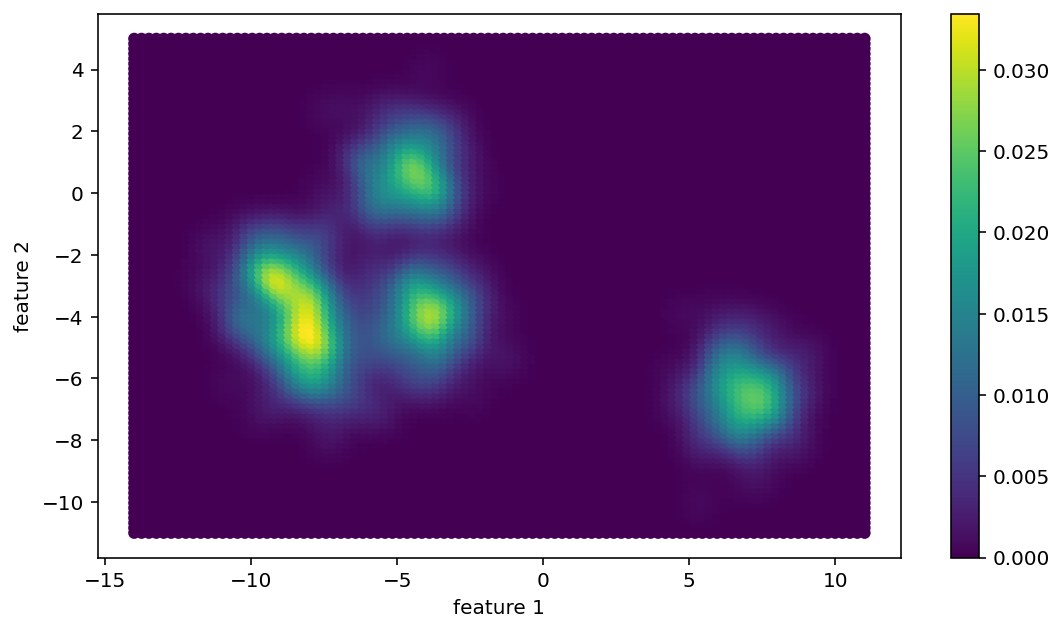

In [139]:
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt)
kde.fit(dataset) #fitting the model to the data

x = np.linspace(-14,11,100)
y = np.linspace(-11,5,100)
Xgrid = np.vstack(map(np.ravel, np.meshgrid(x, y))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluating the model on the grid

#plotting the 2D distribution with the optimal bandwidth
plt.figure(figsize=(9,5))
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, edgecolor="None")
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.colorbar()
plt.show()

#### Part 3

In [83]:
from astroML.density_estimation import KNeighborsDensity

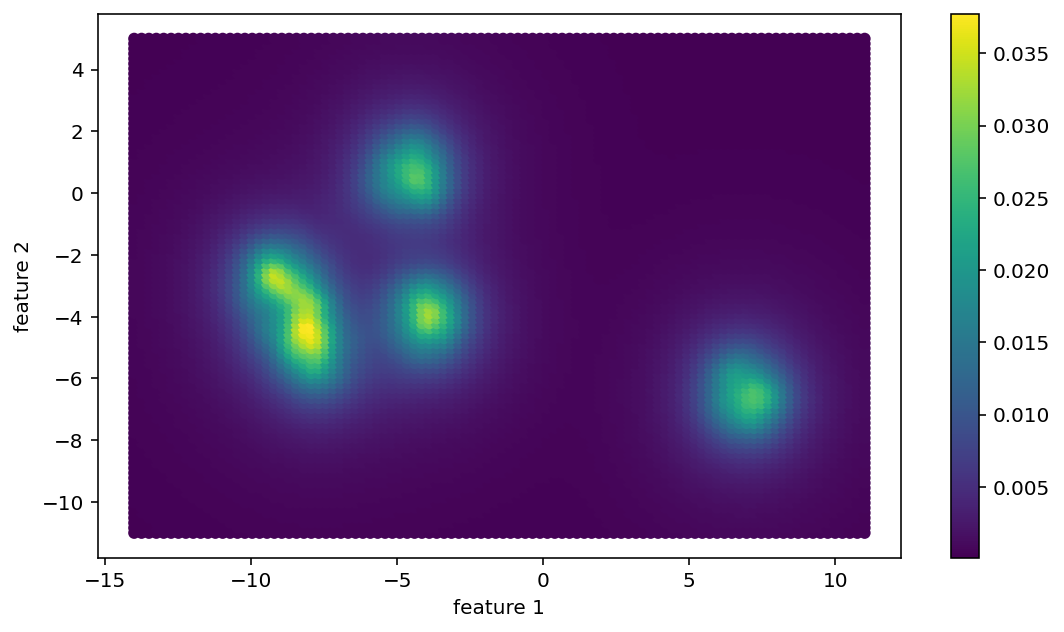

In [231]:
k = 75 #number of neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(dataset)
dens_nbrs = nbrs.eval(Xgrid) / len(f1)

#plotting the 2D distribution with the optimal bandwidth
plt.figure(figsize=(9,5))
plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens_nbrs, edgecolor="None")
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.colorbar()
plt.show()

k=75 neighbors looks pretty similar to the KDE distribution.

SRT: Excellent

#### Part 4

In [85]:
from sklearn.mixture import GaussianMixture

In [86]:
#fitting models with 1-10 components
N = np.arange(1, 11)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(dataset)

#computing the AIC and the BIC
AIC = [m.aic(dataset) for m in models]
BIC = [m.bic(dataset) for m in models]

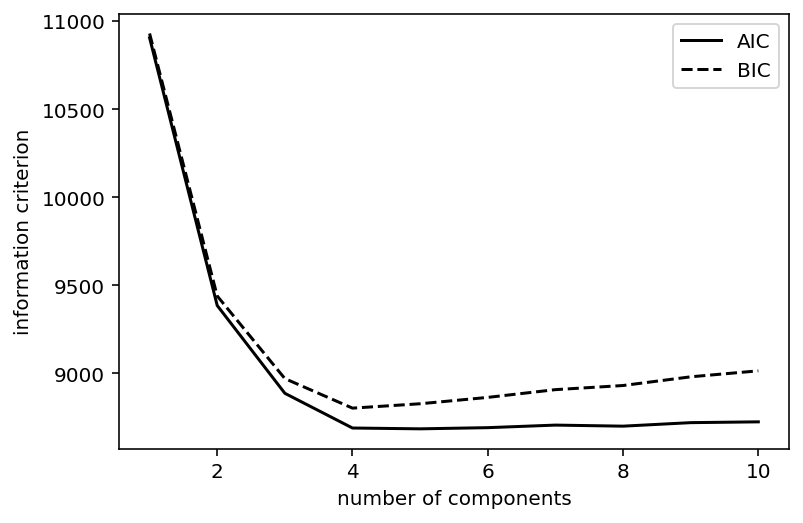

In [87]:
#plotting AIC and BIC values as a function of number of components
plt.plot(N, AIC, '-k', label='AIC')
plt.plot(N, BIC, '--k', label='BIC')
plt.xlabel('number of components')
plt.ylabel('information criterion')
plt.legend()
plt.show()

According to the BIC, 4 components is optimal.

In [232]:
#fitting data with optimal number of GMM components
opt_model = GaussianMixture(4).fit(dataset)

#getting means and covariances of each component, predicting labels
mu = opt_model.means_
cov = opt_model.covariances_
Ls = opt_model.predict(dataset)

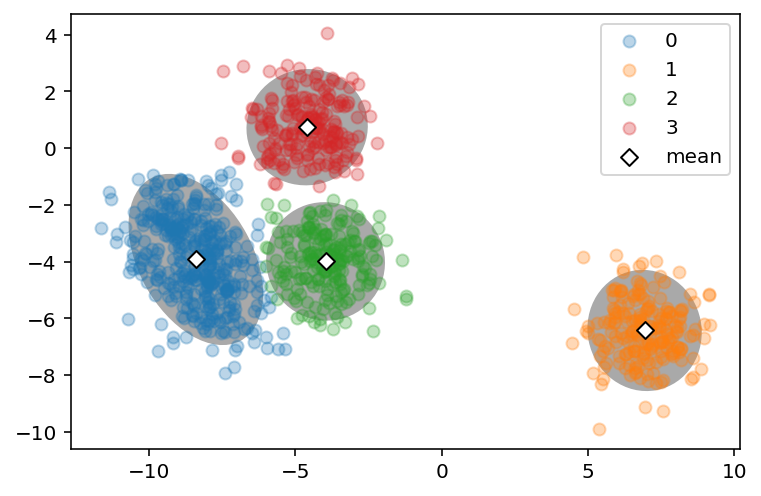

In [245]:
#plotting dataset, means, and 2-sig ellipses
for i in range(4):
    draw_ellipse(mu[i], cov[i], sigmas=[2], color='darkgray')
    ind = np.where(Ls == i)
    plt.scatter(dataset[:,0][ind], dataset[:,1][ind], marker='o', color=colors[i], alpha=0.3, label=f'{i}')
plt.scatter(mu[:,0], mu[:,1], marker='D', c='white', ec='k', label='mean')
plt.legend()
plt.show()

SRT: Awesome, great work Polina.

#### Part 5

In [89]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [118]:
scaler = preprocessing.StandardScaler()
clf = KMeans(n_clusters=5)
clf.fit(scaler.fit_transform(dataset))
cluster_centers = scaler.inverse_transform(clf.cluster_centers_)
labels2 = clf.predict(scaler.transform(dataset))

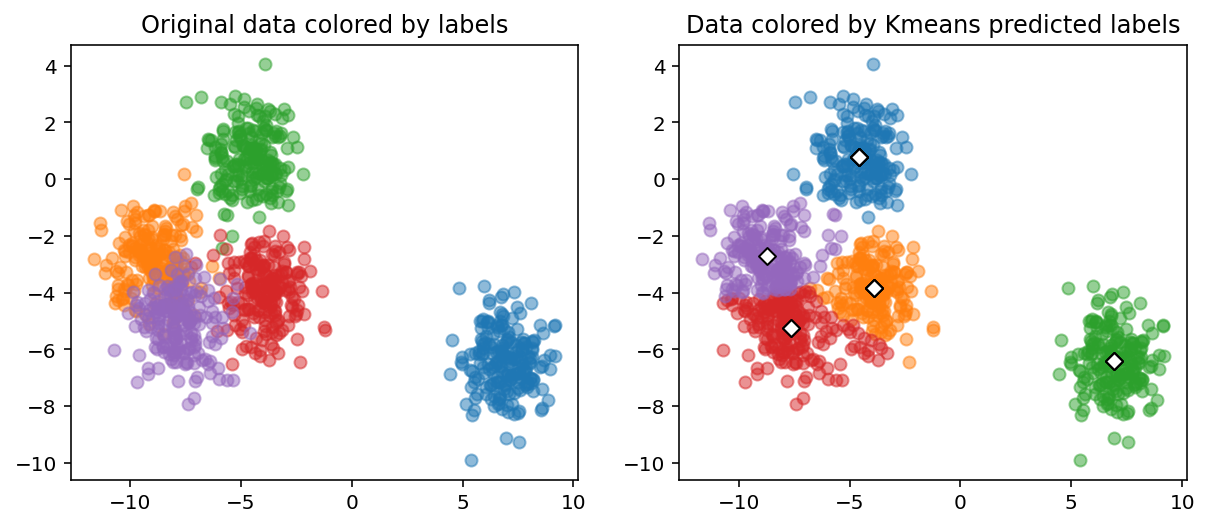

In [243]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
Cs = ['C0', 'C1', 'C2', 'C3', 'C4']

for i,c in zip(range(5),Cs):
    ind = np.where(labels == float(i))
    ax[0].scatter(f1[ind], f2[ind], color=c, marker='o', alpha=0.5, label=str(i))
    ax[0].set_title('Original data colored by labels')

for j in range(5):
    ax[1].scatter(dataset[labels2==j,0], dataset[labels2==j,1], 
                color=colors[j], alpha=0.5)
    ax[1].scatter(cluster_centers[:,0], cluster_centers[:,1], marker='D', c='white', ec='k')
    ax[1].set_title('Data colored by Kmeans predicted labels')
    
plt.show()

SRT: Great!

---

## Problem 2

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data. 

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.

In [144]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to $2$ features. What is the explained variance of the data encapsulated in these eigen-features?


3. Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.


4. Choose $5000$ random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these $5000$ random samples, colored by their corresponding `type`. *(You may want to set the transparency to be lower than 1 to see the mixing of samples.)*


5. Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the $5000$ random samples identified in the previous part. 
    - Try `LocallyLinearEmbedding`, `Isomap`, and `TSNE` algorithms, setting the number of components to be $2$ in all cases. 
    - As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their `type`. For LLE and Isomap, experiment with the number of nearest neighbors between $5$ and $100$ to see what visually gives the best separation in `type` populations. For TSNE, do the same for the perplexity attribute. 
    - Which algorithm gives the cleanest way to visually see the two populations of sources? *(This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)*

### Solution

#### Part 2

In [129]:
from sklearn.decomposition import PCA

In [145]:
#reducing data matrix down to 2 features
pca = PCA(n_components=2)
pca.fit(X)
evals = pca.explained_variance_ratio_ 
print('Expained fractional variance of data encapsulated in the eigenvalues: ' + str(evals))
print("All components explain {:.3f} of the variance in the data.".format(sum(pca.explained_variance_ratio_)))

Expained fractional variance of data encapsulated in the eigenvalues: [0.53320897 0.25010565]
All components explain 0.783 of the variance in the data.


SRT: Very good.

#### Part 3

In [154]:
dataLabels = data['type']
print(dataLabels)

[3 6 3 ... 3 6 3]


From https://www.astroml.org/modules/generated/astroML.datasets.fetch_imaging_sample.html#astroML.datasets.fetch_imaging_sample, the "type" key tells if a source is resolved or not. Type 3 corresponds to resolved (galaxies), and type 6 corresponds to unresolved (stars or quasars).

#### Part 4

In [179]:
from numpy.random import randint

In [180]:
#recording 5000 random indices
randSample = randint(0, len(X), 5000)

In [181]:
#getting subsets of data, types corresponding to indices and reducing to 2 features
Xsample = X[randSample]
Tsample = dataLabels[randSample]
pca2 = PCA(n_components=2)
pca2.fit(Xsample)
Xr = pca2.transform(Xsample)

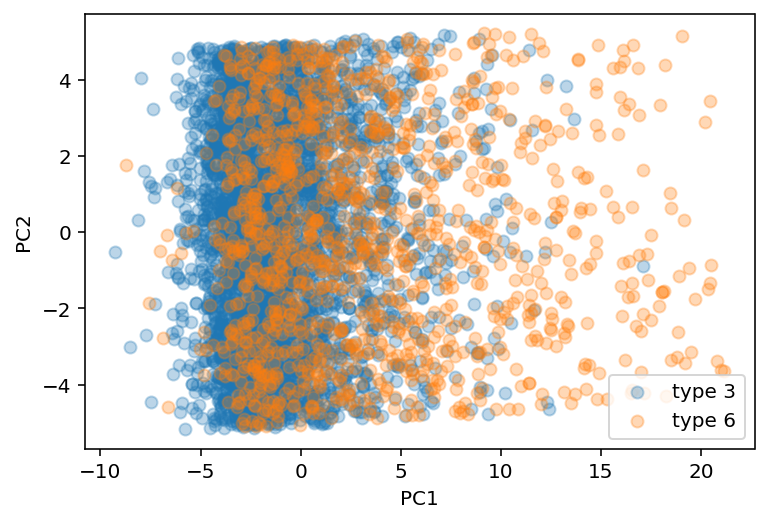

In [182]:
#plotting PCA-reduced data for the 5000 random samples, colored by type 
for i,t in zip(range(2), [3,6]):
    index = np.where(Tsample == t)
    plt.scatter(Xr[:,0][index], Xr[:,1][index], marker='o', alpha=0.3, label=f'type {t}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

#### Part 5

In [183]:
#LocallyLinearEmbedding
from sklearn.manifold import LocallyLinearEmbedding

In [196]:
n = 2 #number of components
k_vals = np.linspace(5, 100, 10) #trying out 10 different k values between 5 and 100
k_vals = np.array([int(v) for v in k_vals]) #previous line gives floats, turning these into ints
print(k) #to see what k vals are being tested

[  5  15  26  36  47  57  68  78  89 100]


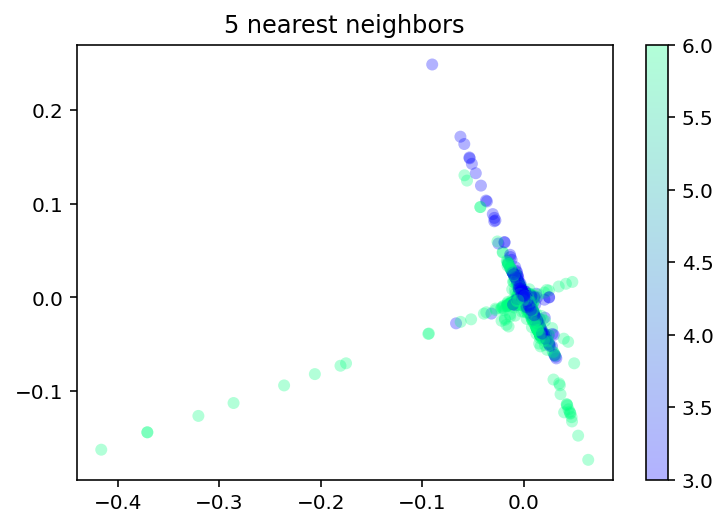

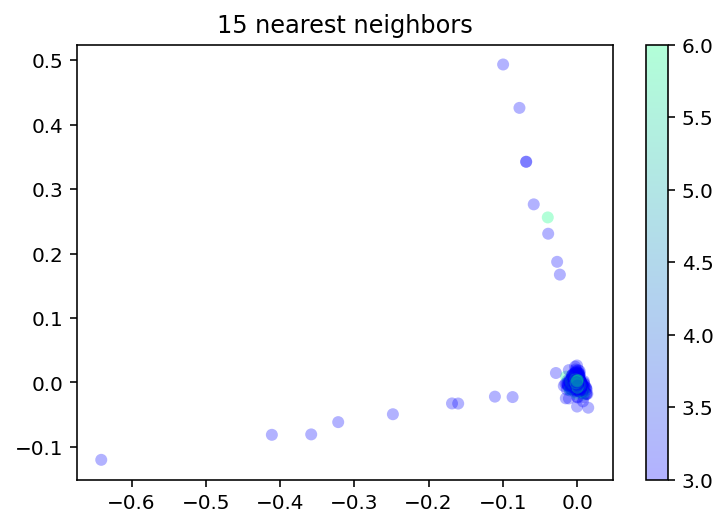

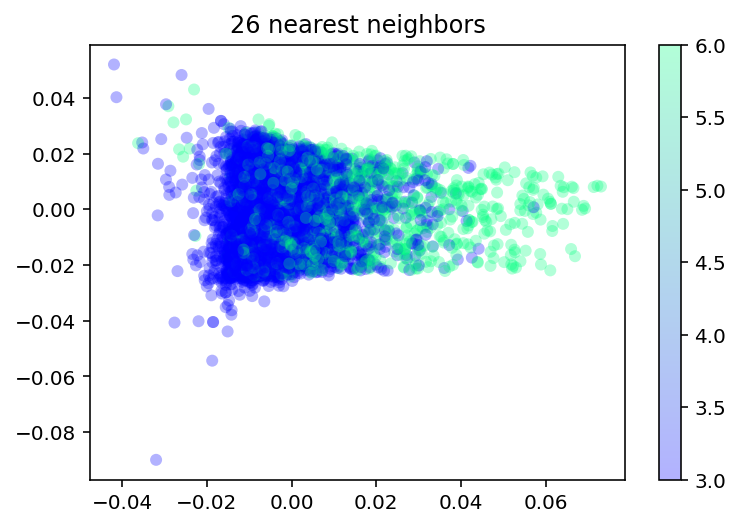

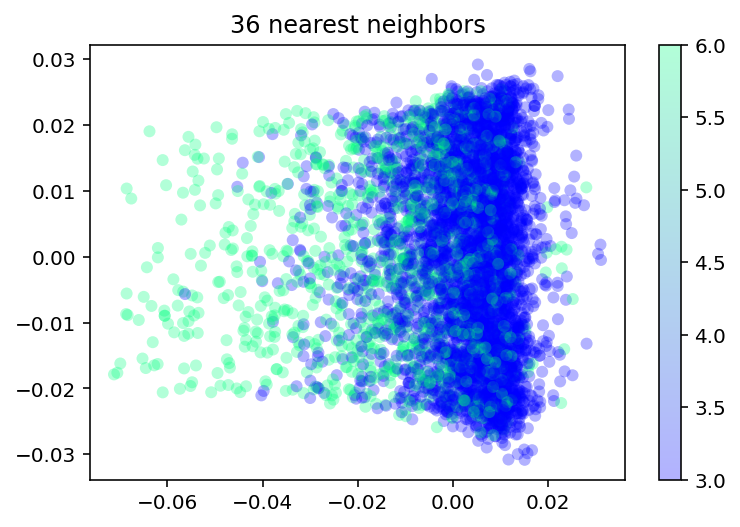

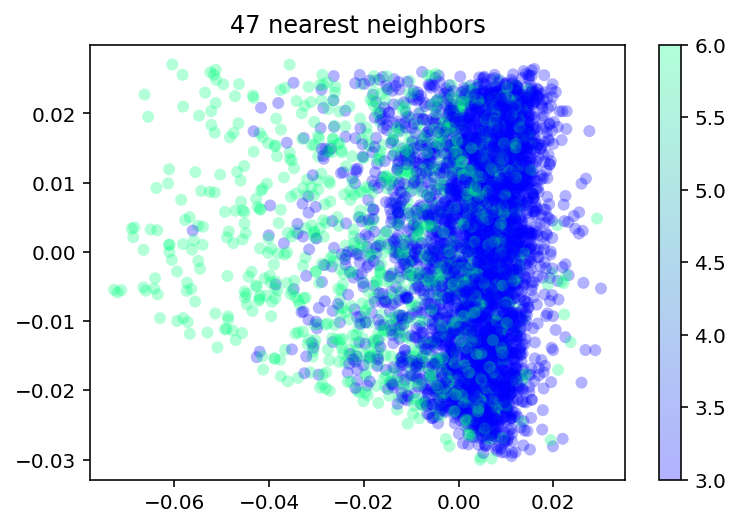

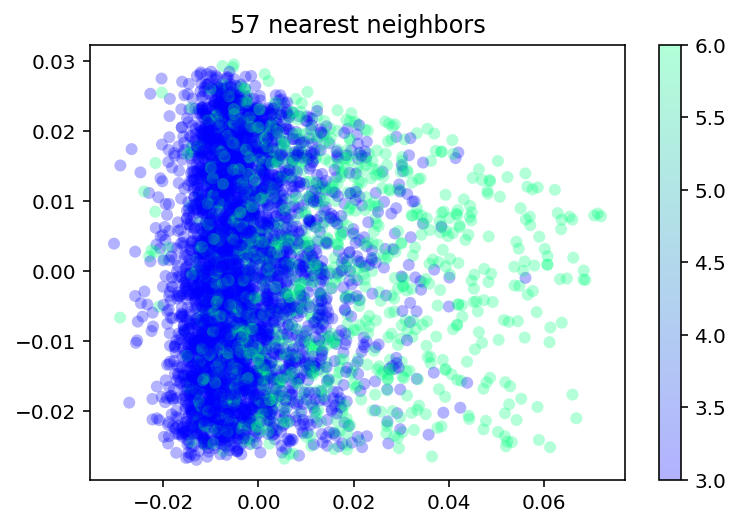

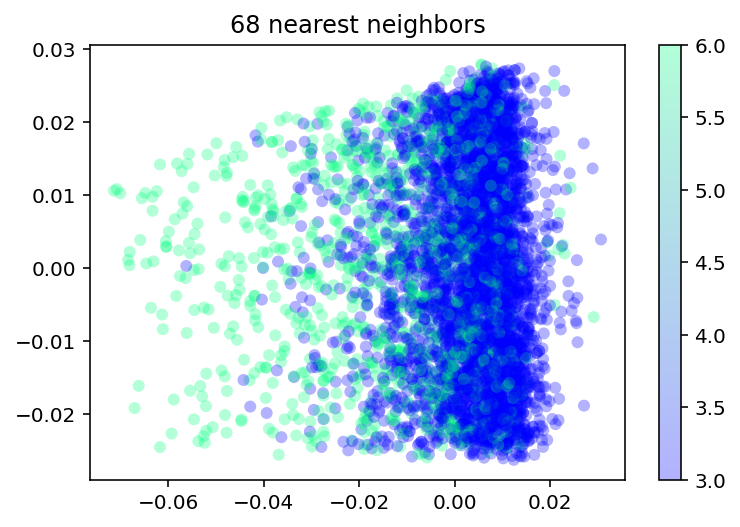

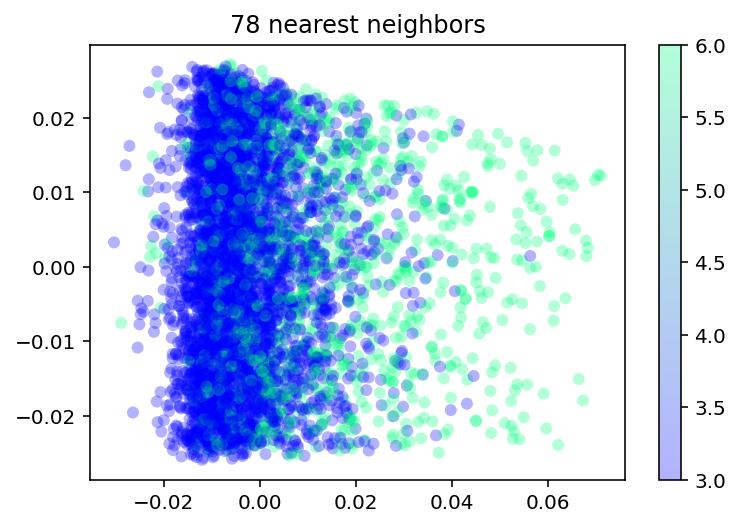

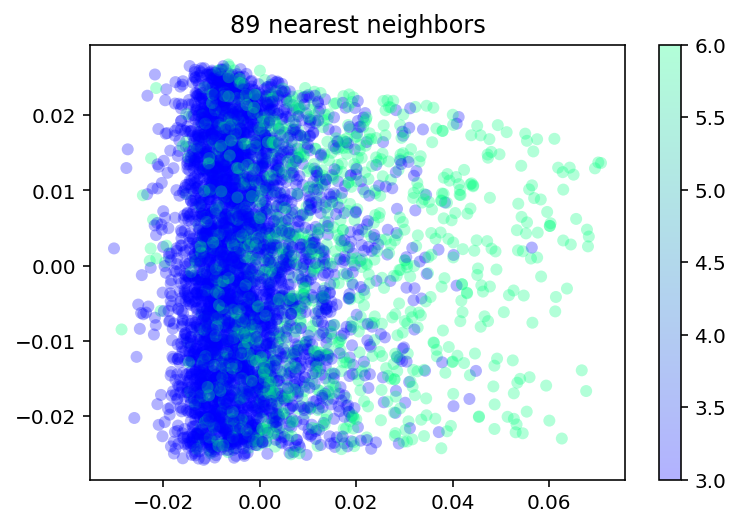

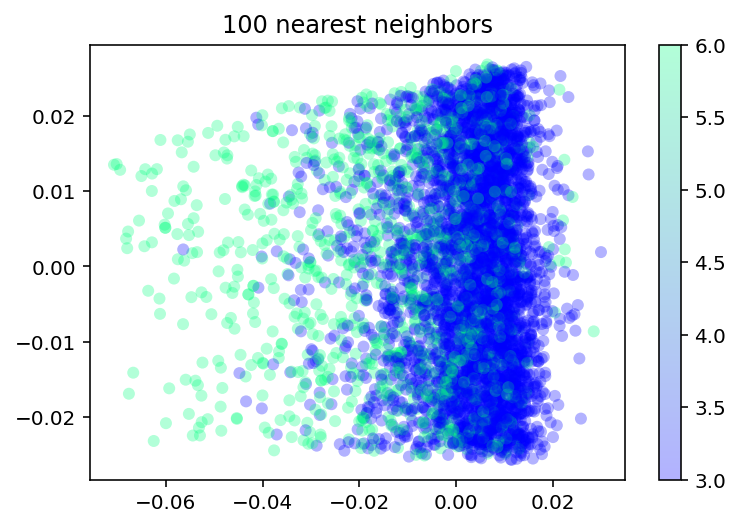

In [210]:
#plotting for each k
for i,k in enumerate(k_vals):
    lle = LocallyLinearEmbedding(n_neighbors=k, n_components=n)
    lle.fit(Xsample)
    Xred = lle.transform(Xsample)
    plt.figure(i)
    plt.scatter(Xred[:,0], Xred[:,1], c=Tsample, cmap='winter', edgecolor='None', alpha=0.3)
    plt.title(f'{k} nearest neighbors')
    plt.colorbar()

In [211]:
#Isomap
from sklearn.manifold import Isomap

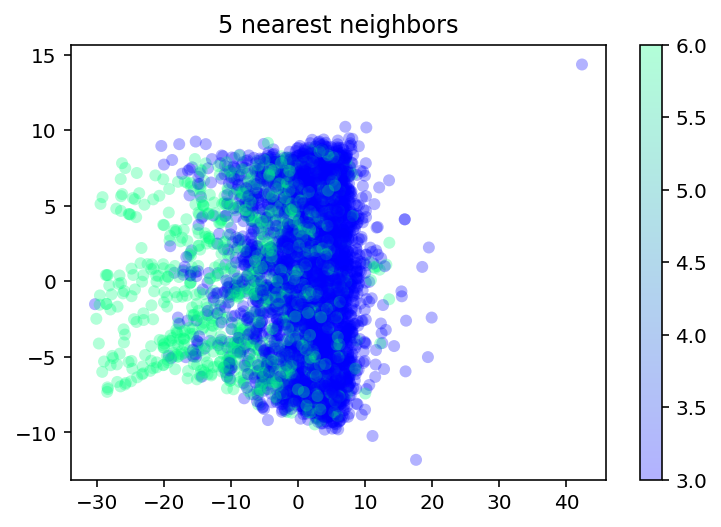

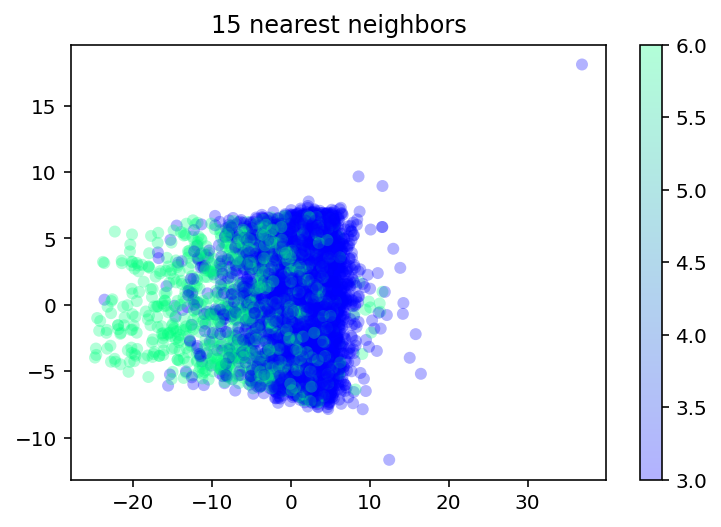

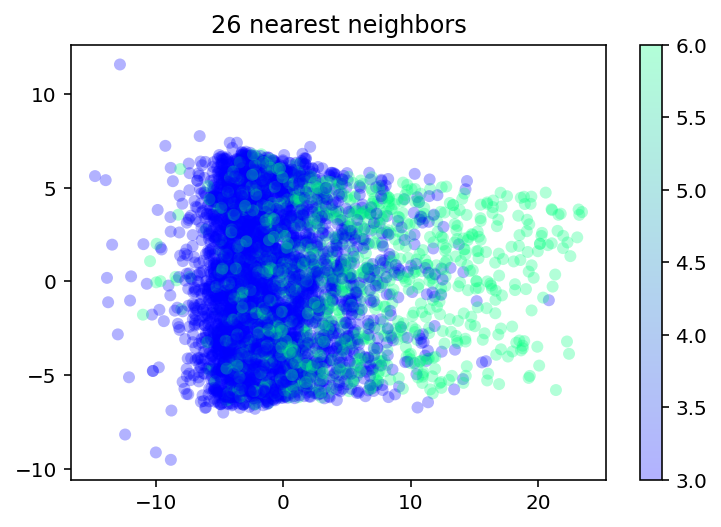

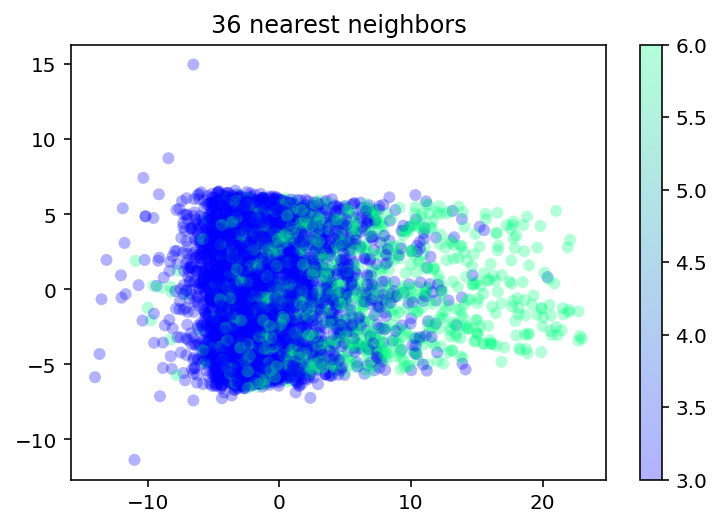

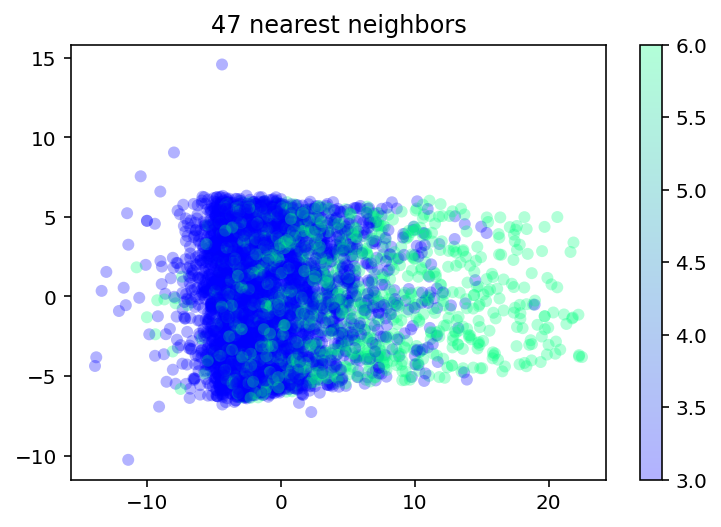

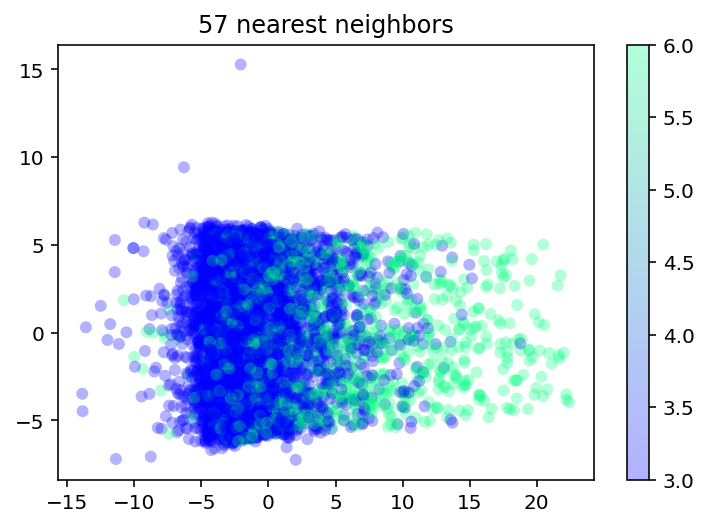

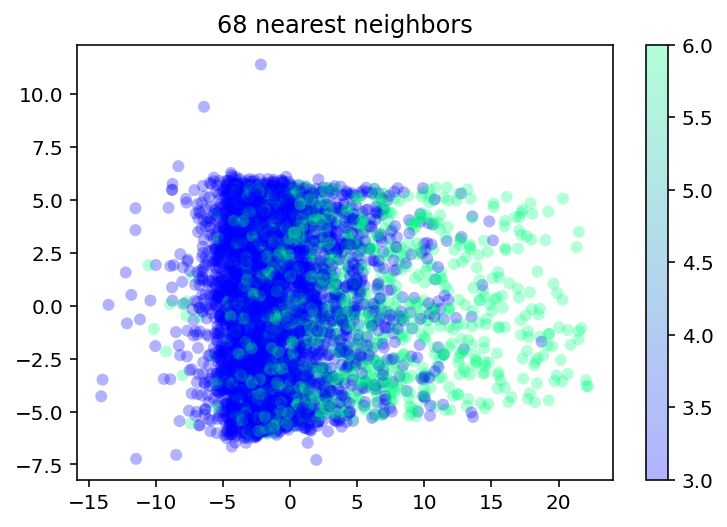

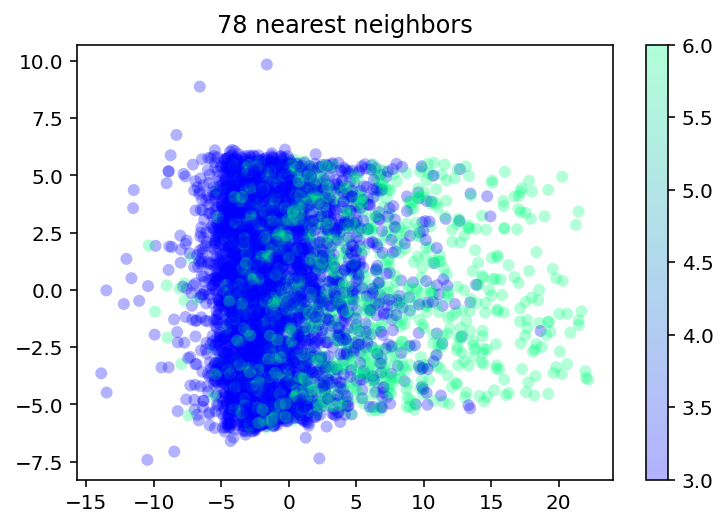

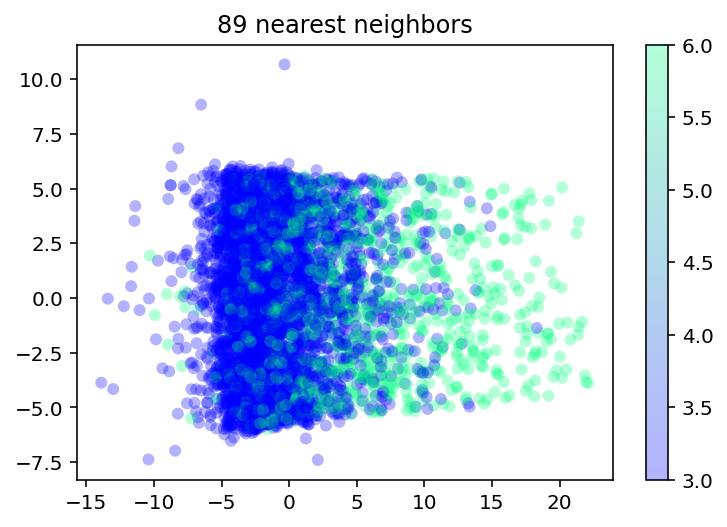

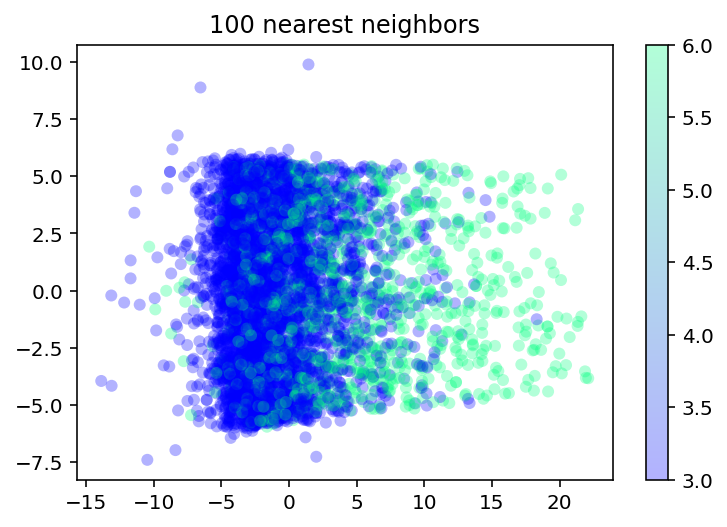

In [212]:
#plotting for each k
for i,k in enumerate(k_vals):
    iso = Isomap(n_neighbors=k, n_components=n)
    iso.fit(Xsample)
    Xred = iso.transform(Xsample)
    plt.figure(i)
    plt.scatter(Xred[:,0], Xred[:,1], c=Tsample, cmap='winter', edgecolor='None', alpha=0.3)
    plt.title(f'{k} nearest neighbors')
    plt.colorbar()

In [213]:
# t-SNE
from sklearn.manifold import TSNE

/Users/petrop3/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/petrop3/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/petrop3/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/petrop3/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/petrop3/anaconda3/envs/astr8070/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change fro

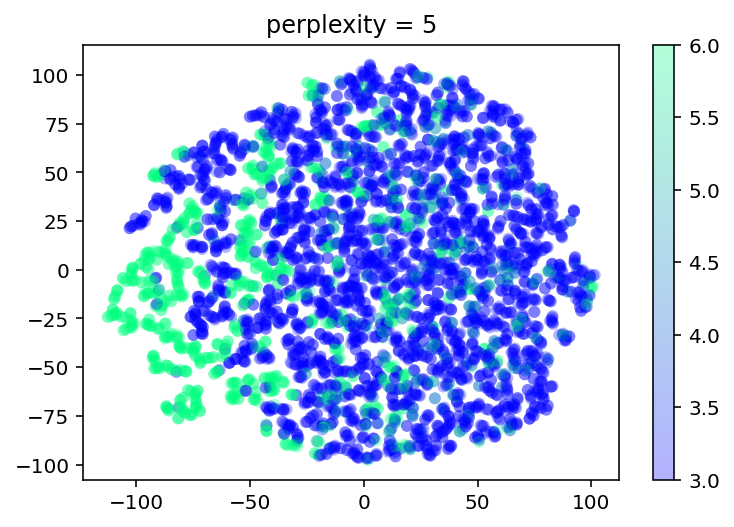

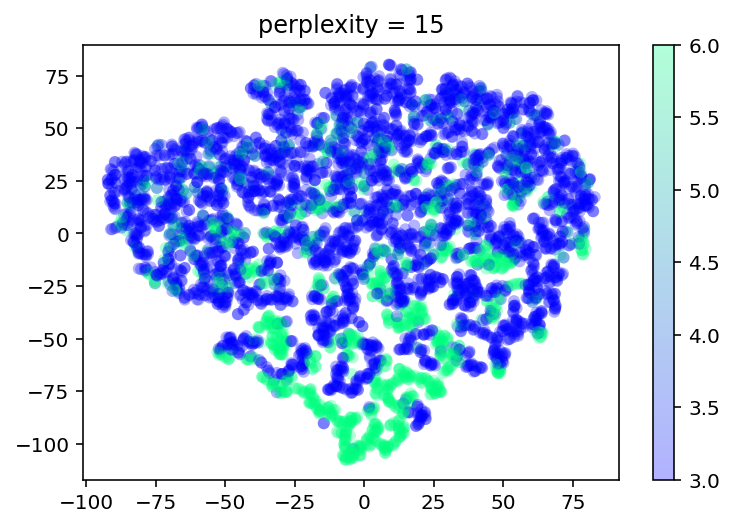

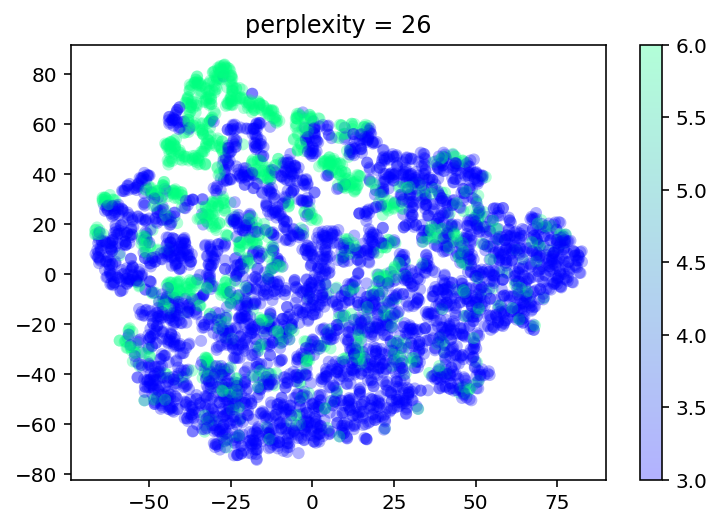

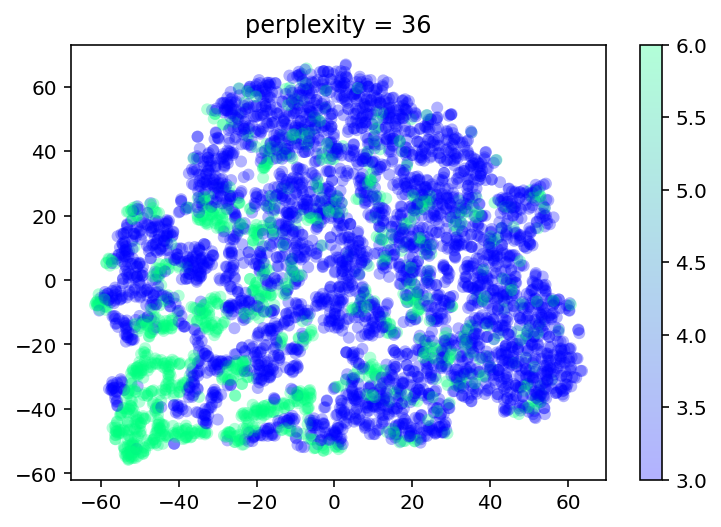

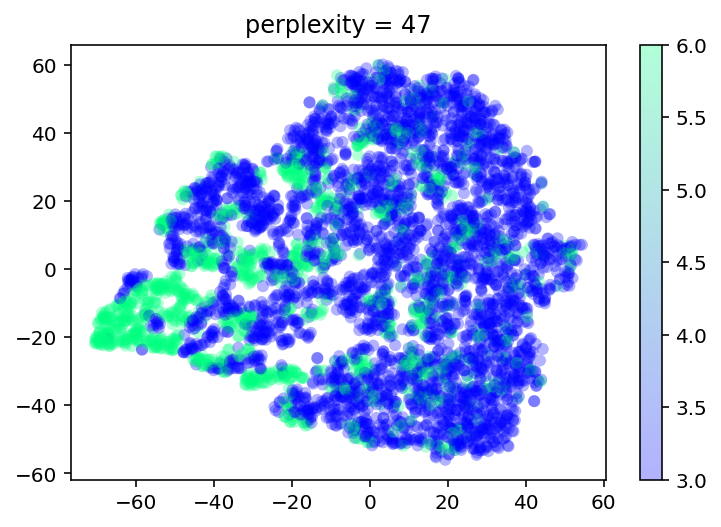

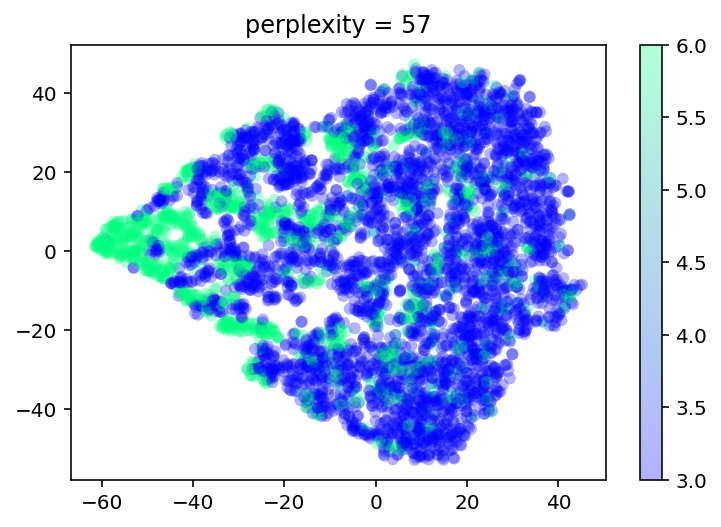

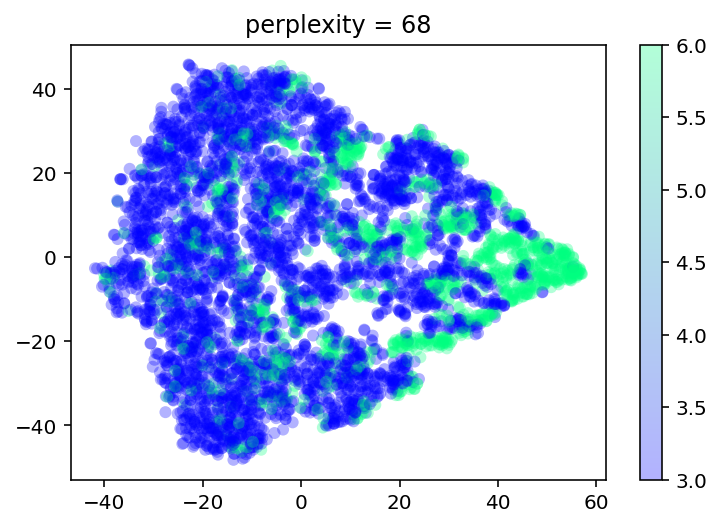

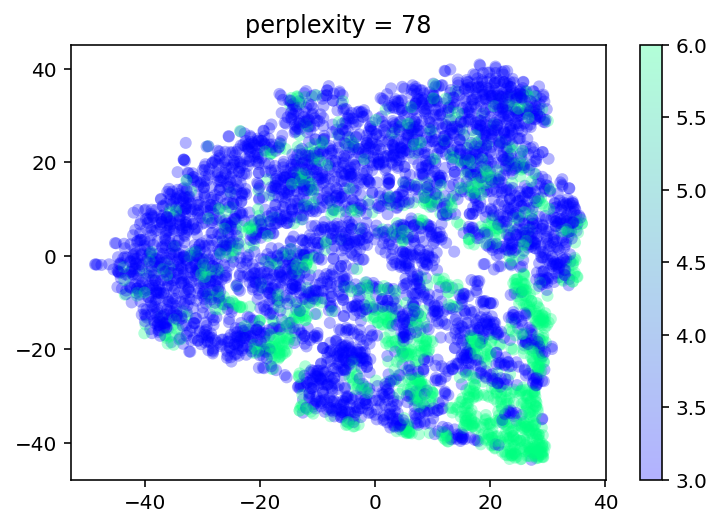

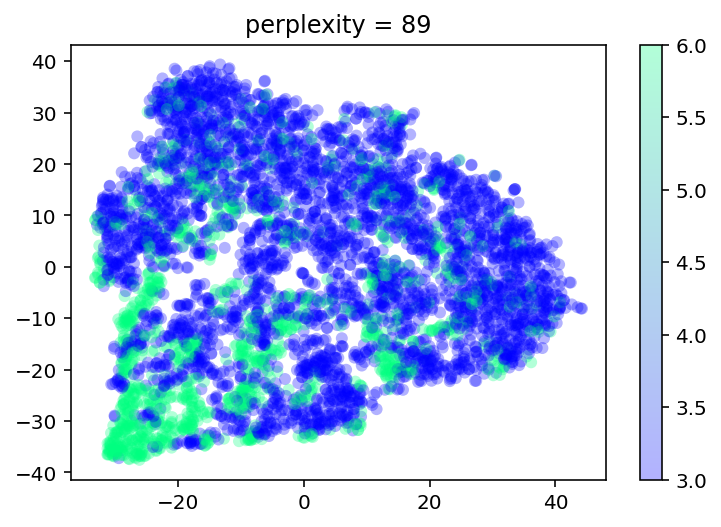

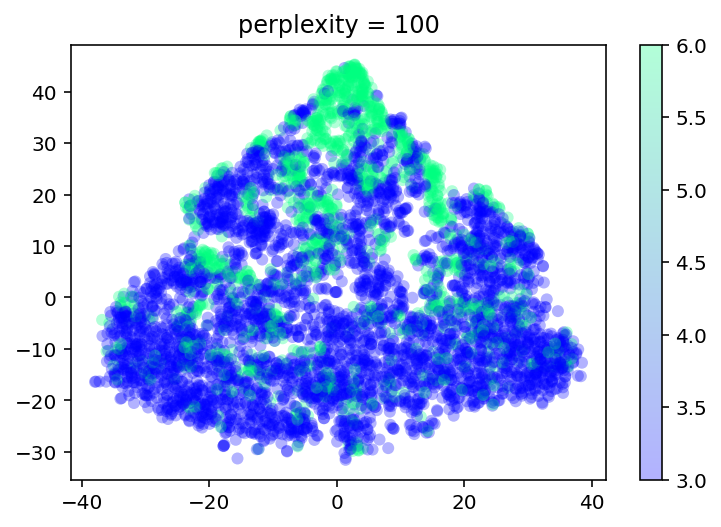

In [215]:
#plotting for each k
for i,k in enumerate(k_vals):
    tsne = TSNE(n_components=n, perplexity=k, learning_rate=200)
    Xred = tsne.fit_transform(Xsample)
    plt.figure(i)
    plt.scatter(Xred[:,0], Xred[:,1], c=Tsample, cmap='winter', edgecolor='None', alpha=0.3)
    plt.title(f'perplexity = {k}')
    plt.colorbar()

Given that there's a considerable amount of overlap between the two populations using any of the three algorithms, deciding on the best one is pretty difficult. I think maybe TSNE does the best in terms of actually separating the two populations, but LLE or Isomap are cleaner in that it's easier to make sense of them (not as oddly shaped as what TSNE produces).

SRT: Very good commentary! I agree with the efficacy of TSNE in separating the populations.